# Sentiment Analysis with TensorFlow
In this notebook, we will use TensorFlow to classify human emotion based on text.

## Importing the required library

In [24]:
import tensorflow as tf
import numpy as np
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Download and import the Dataset
For this project, we will use the emotion dataset from huggingface.co. The full description and dataset are available in this link https://huggingface.co/datasets/dair-ai/emotion

In [25]:
!sudo apt install jq
!rm data.json data.jsonl data.jsonl.gz
!wget https://huggingface.co/datasets/dair-ai/emotion/resolve/main/data/data.jsonl.gz
!gunzip data.jsonl.gz
!jq --slurp . < data.jsonl > data.json
!rm data.jsonl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
jq is already the newest version (1.6-1ubuntu0.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
rm: cannot remove 'data.jsonl': No such file or directory
rm: cannot remove 'data.jsonl.gz': No such file or directory
--2023-06-17 00:43:20--  https://huggingface.co/datasets/dair-ai/emotion/resolve/main/data/data.jsonl.gz
Resolving huggingface.co (huggingface.co)... 18.155.68.44, 18.155.68.116, 18.155.68.121, ...
Connecting to huggingface.co (huggingface.co)|18.155.68.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/datasets/emotion/8944e6b35cb42294769ac30cf17bd006231545b2eeecfa59324246e192564d1f?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27data.jsonl.gz%3B+filename%3D%22data.jsonl.gz%22%3B&response-content-type=application%2Fgzip&Expires=1687221801&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmN

In [26]:
#Load the JSON file
with open("data.json", 'r') as f:
  datastore = json.load(f)

#Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
  sentences.append(item['text'])
  labels.append(item['label'])


In [27]:
# Split the dataset into 80% train data and 20% test data
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Print the length of the train and test dataset
print(f"Train dataset size: {len(train_sentences)}")
print(f"Test dataset size: {len(test_sentences)}")

Train dataset size: 333447
Test dataset size: 83362


In [28]:
print(len(train_sentences))
print(len(train_labels))

print(len(test_sentences))
print(len(test_labels))

333447
333447
83362
83362


In [29]:
# Print the first 10 sentences and labels of the train data
print("Train Data:")
for sentence, label in zip(train_sentences[:10], train_labels[:10]):
    print("Sentence:", sentence)
    print("Label:", label)
    print()

# Print the first 10 sentences and labels of the test data
print("Test Data:")
for sentence, label in zip(test_sentences[:10], test_labels[:10]):
    print("Sentence:", sentence)
    print("Label:", label)
    print()

Train Data:
Sentence: im sharing what weve done and learned only because when i was making decisions about what was best for our family it was really intimidating for me to get good advice from people without feeling pressured from one side or the other
Label: 4

Sentence: i sit quietly trying to get other work done but feeling largely useless
Label: 0

Sentence: i feel very jolly
Label: 1

Sentence: i like to keep it on my desk for a middle of the day pick me up when im feeling stressed
Label: 3

Sentence: i feel the witness is sincere
Label: 1

Sentence: im not scared of needles but after having one too many painful jabs in rapid sucession i admit to now feeling apprehensive every time i know i need to have an injection
Label: 4

Sentence: i don t actually want a us college education even if it would make me feel much more intelligent but there is sun in california
Label: 1

Sentence: i reach the quiet road and skim down the pavement feeling the cool spring wind blowing my face
Label

## Data Preprocessing
In this section, we will use the Tokenizer function to tokenize the sentences

In [30]:
# Initialize the required variables
vocab_size = 20000
max_length = 120
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(train_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy array
training_labels = np.array(train_labels)
testing_labels = np.array(test_labels)


In [31]:
# Print the result from the tokenizing and padding process
print(len(training_labels))
print(len(training_padded))

print(len(testing_labels))
print(len(testing_padded))

333447
333447
83362
83362


## Build and Compile the Model
Now, we will build and compile our model using TensorFlow. We will use several neuron layers such as embedding, bidirectional, and convolution.

In [32]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SpatialDropout1D(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=32)),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')

])

# Set the training parameters
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           320000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 120, 16)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 120, 64)          12544     
 nal)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 116, 128)          41088     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                      

## Train the model
We will train the model and see the result

In [33]:
num_epochs = 30
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3)

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=[early_stopping], verbose=2)

Epoch 1/30
10421/10421 - 168s - loss: 0.3357 - accuracy: 0.8803 - val_loss: 0.1378 - val_accuracy: 0.9381 - 168s/epoch - 16ms/step
Epoch 2/30
10421/10421 - 139s - loss: 0.1486 - accuracy: 0.9331 - val_loss: 0.1109 - val_accuracy: 0.9383 - 139s/epoch - 13ms/step
Epoch 3/30
10421/10421 - 138s - loss: 0.1296 - accuracy: 0.9352 - val_loss: 0.1085 - val_accuracy: 0.9370 - 138s/epoch - 13ms/step
Epoch 4/30
10421/10421 - 136s - loss: 0.1223 - accuracy: 0.9363 - val_loss: 0.1086 - val_accuracy: 0.9388 - 136s/epoch - 13ms/step
Epoch 5/30
10421/10421 - 135s - loss: 0.1170 - accuracy: 0.9373 - val_loss: 0.1048 - val_accuracy: 0.9395 - 135s/epoch - 13ms/step
Epoch 6/30
10421/10421 - 128s - loss: 0.1141 - accuracy: 0.9377 - val_loss: 0.1049 - val_accuracy: 0.9391 - 128s/epoch - 12ms/step
Epoch 7/30
10421/10421 - 129s - loss: 0.1113 - accuracy: 0.9387 - val_loss: 0.1077 - val_accuracy: 0.9387 - 129s/epoch - 12ms/step
Epoch 8/30
10421/10421 - 136s - loss: 0.1093 - accuracy: 0.9391 - val_loss: 0.1035 

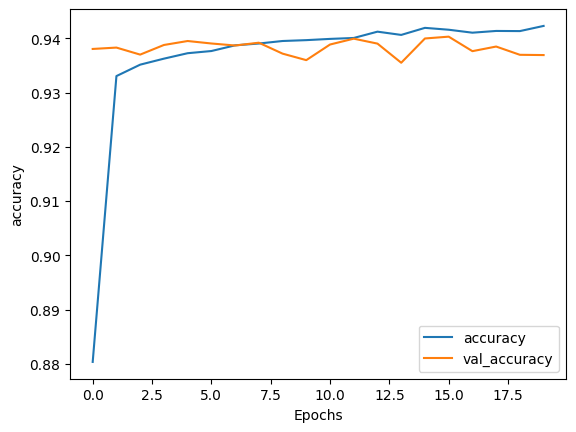

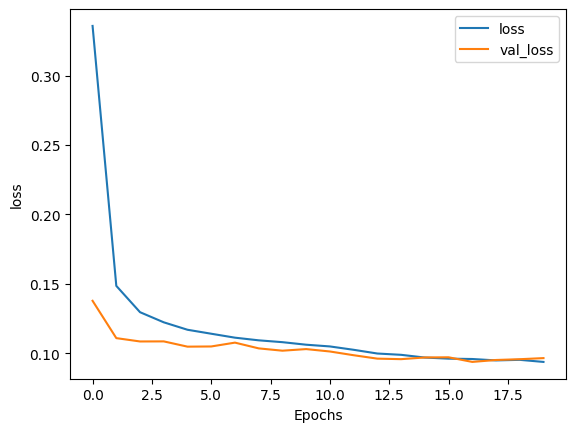

In [34]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

As you can see from the plot above, our model seems good enough. The training accuracy and validation accuracy are linear to each other. On the other side, the training loss and validatoin loss are also linear to each other. We can say that our model is not overfitting. Although there may be some tweaks we can do to make the model better.